In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem

def cartesian_to_internal(cart_coords):
    mol = Chem.RWMol()
    conf = Chem.Conformer(len(cart_coords))
    for i, atom in enumerate(cart_coords):
        atom_symbol, x, y, z = atom
        atom_idx = mol.AddAtom(Chem.Atom(atom_symbol))
        conf.SetAtomPosition(atom_idx, (x, y, z))
    mol.AddConformer(conf)
    
    # Calculate explicit valence before optimization
    Chem.SanitizeMol(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    internal_coords = []
    for i in range(len(cart_coords)):
        for j in range(i + 1, len(cart_coords)):
            d = conf.GetAtomPosition(i).Distance(conf.GetAtomPosition(j))
            internal_coords.append((i, j, d))
    return internal_coords

In [9]:
def internal_to_cartesian(internal_coords, ratio, start_coords, end_coords):
    interp_coords = []
    for (i, j, d_start), (_, _, d_end) in zip(internal_coords, internal_coords):
        d_interp = d_start + ratio * (d_end - d_start)
        x = start_coords[i][1] + ratio * (end_coords[i][1] - start_coords[i][1])
        y = start_coords[i][2] + ratio * (end_coords[i][2] - start_coords[i][2])
        z = start_coords[i][3] + ratio * (end_coords[i][3] - start_coords[i][3])
        interp_coords.append((start_coords[i][0], x, y, z))
        x = start_coords[j][1] + ratio * (end_coords[j][1] - start_coords[j][1])
        y = start_coords[j][2] + ratio * (end_coords[j][2] - start_coords[j][2])
        z = start_coords[j][3] + ratio * (end_coords[j][3] - start_coords[j][3])
        interp_coords.append((start_coords[j][0], x, y, z))
    return interp_coords

In [4]:
start_coords = [
    ('N', 1.2313824, 1.1780945, 0.0377734),
    ('N', 1.1654720, -1.1706670, -0.1001751),
    ('N', -0.7702714, 2.5020692, 0.0477168),
    ('N', -0.9070720, -2.3727728, -0.2384904),
    ('N', 3.2890720, -0.0588251, 0.0347267),
    ('H', -1.9553412, 0.0980196, -0.1300470),
    ('C', -0.8731371, 0.0656571, -0.0960979),
    ('C', -0.1258712, 1.2442549, -0.0033584),
    ('C', -0.1932165, -1.1556070, -0.1442806),
    ('C', 1.8784371, -0.0166267, -0.0097757),
    ('H', -0.2143659, 3.3668201, 0.1155597),
    ('H', -1.7981168, 2.5706918, 0.0176526),
    ('H', -1.9370492, -2.3798691, -0.2727799),
    ('H', -0.4005870, -3.2692251, -0.2741807),
    ('H', 3.7845336, -0.9614087, -0.0009100),
    ('H', 3.8343121, 0.8126153, 0.1033901)
]

end_coords = [
  N    1.2313824    1.1780945    0.0377734
  N    1.1654720   -1.1706670   -0.1001751
  N   -0.7702714    2.5020692    0.0477168
  N   -0.9070720   -2.3727728   -0.2384904
  N    3.2890720   -0.0588251    0.0347267
  H   -1.9553412    0.0980196   -0.1300470
  C   -0.8731371    0.0656571   -0.0960979
  C   -0.1258712    1.2442549   -0.0033584
  C   -0.1932165   -1.1556070   -0.1442806
  C    1.8784371   -0.0166267   -0.0097757
  H   -1.2064709    2.8956677   -0.7985916
  H   -0.8124841    3.0387433    0.9265104
  H   -1.9370492   -2.3798691   -0.2727799
  H   -0.4005870   -3.2692251   -0.2741807
  H    3.7845336   -0.9614087   -0.0009100
  H    3.8343121    0.8126153    0.1033901
    # ('N', 1.2018922181757576, 0.6893761889363637, 1.6207560606060606e-05),
    # ('N', -1.2018593634242425, 0.6894331940363637, 2.7575260606060606e-05),
    # ('N', 2.4037579727757574, -1.2554012997636363, -7.143439393939393e-06),
    # ('N', -2.4038174167242428, -1.2552873285636363, -1.0541393939393933e-06),
    # ('N', 6.269057575760375e-05, 2.6378274963363637, 3.14199606060606e-05),
    # ('H', -5.9080724242396236e-05, -2.468661680763636, -0.0001423301393939394),
    # ('C', -3.291972424239623e-05, -1.3881635710636364, -9.65821393939394e-05),
    # ('C', 1.1826934433757577, -0.6509036727636364, -3.3661439393939394e-05),
    # ('C', -1.1827250358242425, -0.6508466952636364, -2.8252139393939394e-05),
    # ('C', 3.049007575760376e-05, 1.2776164115363637, 1.9678760606060608e-05),
    # ('H', 3.2219681144757573, -0.6753589578636363, 0.00034411876060606064),
    # ('H', 2.4954238773757575, -2.252144709563636, 3.768166060606061e-05),
    # ('H', -2.4955292826242426, -2.252026397963636, -9.94433393939394e-05),
    # ('H', -3.2220006721242425, -0.6752069731636363, 0.00038486546060606064),
    # ('H', -0.8733884357242424, 3.127793611836364, -5.261063939393939e-05),
    # ('H', 0.8735369022757576, 3.1277525159363635, -0.00010841643939393939)
]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1131447122.py, line 2)

In [4]:

internal_coords = cartesian_to_internal(start_coords)
ratio = 0.5  # Change this value for different interpolation ratios
interp_coords = internal_to_cartesian(internal_coords, ratio, start_coords, end_coords)
for atom in interp_coords:
    print('{:2s} {: .7f} {: .7f} {: .7f}'.format(*atom))


N   1.2166373  0.9337353  0.0188948
N  -0.0181937 -0.2406169 -0.0500738
N   1.2166373  0.9337353  0.0188948
N   0.8167433  0.6233340  0.0238548
N   1.2166373  0.9337353  0.0188948
N  -1.6554447 -1.8140301 -0.1192457
N   1.2166373  0.9337353  0.0188948
N   1.6445673  1.2895012  0.0173791
N   1.2166373  0.9337353  0.0188948
H  -0.9777001 -1.1853210 -0.0650947
N   1.2166373  0.9337353  0.0188948
C  -0.4365850 -0.6612532 -0.0480972
N   1.2166373  0.9337353  0.0188948
C   0.5284111  0.2966756 -0.0016960
N   1.2166373  0.9337353  0.0188948
C  -0.6879708 -0.9032268 -0.0721544
N   1.2166373  0.9337353  0.0188948
C   0.9392338  0.6304949 -0.0048780
N   1.2166373  0.9337353  0.0188948
H   1.5038011  1.3457306  0.0579519
N   1.2166373  0.9337353  0.0188948
H   0.3486535  0.1592735  0.0088451
N   1.2166373  0.9337353  0.0188948
H  -2.2162892 -2.3159477 -0.1364397
N   1.2166373  0.9337353  0.0188948
H  -1.8112938 -1.9722160 -0.1368979
N   1.2166373  0.9337353  0.0188948
H   1.4555726  1.0831925 -0.

[13:30:14] Molecule does not have explicit Hs. Consider calling AddHs()
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] WARNING: not removing hydrogen atom without neighbors
[13:30:14] Molecule does not have explicit Hs. Consider calling AddHs()


In [5]:
interp_coords = internal_to_cartesian(internal_coords, ratio, start_coords, end_coords)


In [6]:
for atom in interp_coords:
    print('{:2s} {: .7f} {: .7f} {: .7f}'.format(*atom))

N   1.2166373  0.9337353  0.0188948
N  -0.0181937 -0.2406169 -0.0500738
N   1.2166373  0.9337353  0.0188948
N   0.8167433  0.6233340  0.0238548
N   1.2166373  0.9337353  0.0188948
N  -1.6554447 -1.8140301 -0.1192457
N   1.2166373  0.9337353  0.0188948
N   1.6445673  1.2895012  0.0173791
N   1.2166373  0.9337353  0.0188948
H  -0.9777001 -1.1853210 -0.0650947
N   1.2166373  0.9337353  0.0188948
C  -0.4365850 -0.6612532 -0.0480972
N   1.2166373  0.9337353  0.0188948
C   0.5284111  0.2966756 -0.0016960
N   1.2166373  0.9337353  0.0188948
C  -0.6879708 -0.9032268 -0.0721544
N   1.2166373  0.9337353  0.0188948
C   0.9392338  0.6304949 -0.0048780
N   1.2166373  0.9337353  0.0188948
H   1.5038011  1.3457306  0.0579519
N   1.2166373  0.9337353  0.0188948
H   0.3486535  0.1592735  0.0088451
N   1.2166373  0.9337353  0.0188948
H  -2.2162892 -2.3159477 -0.1364397
N   1.2166373  0.9337353  0.0188948
H  -1.8112938 -1.9722160 -0.1368979
N   1.2166373  0.9337353  0.0188948
H   1.4555726  1.0831925 -0.

Starting Structure:
Ending Structure:
Interpolated Structure (ratio=0.5):


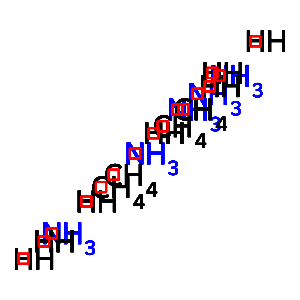

In [8]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.display import display

# Function to visualize molecules
def visualize_molecule(coords):
    mol = Chem.RWMol()
    conf = Chem.Conformer(len(coords))
    for i, atom in enumerate(coords):
        atom_symbol, x, y, z = atom
        atom_idx = mol.AddAtom(Chem.Atom(atom_symbol))
        conf.SetAtomPosition(atom_idx, (x, y, z))
    mol.AddConformer(conf)
    return mol.GetMol()

# Visualize the starting structure
start_mol = visualize_molecule(start_coords)
print("Starting Structure:")
Draw.MolToImage(start_mol)

# Visualize the ending structure
end_mol = visualize_molecule(end_coords)
print("Ending Structure:")
Draw.MolToImage(end_mol)

# Interpolate coordinates
interp_coords = internal_to_cartesian(internal_coords, ratio, start_coords, end_coords)
interp_mol = visualize_molecule(interp_coords)

# Visualize the interpolated structure
print("Interpolated Structure (ratio={}):".format(ratio))
Draw.MolToImage(interp_mol)



Starting Structure:
Ending Structure:


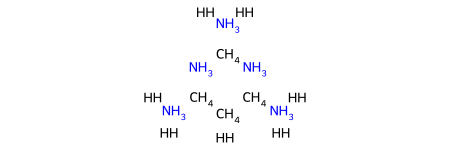

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

def visualize_molecule(coords):
    mol = Chem.RWMol()
    conf = Chem.Conformer(len(coords))
    for i, atom in enumerate(coords):
        atom_symbol, x, y, z = atom
        atom_idx = mol.AddAtom(Chem.Atom(atom_symbol))
        conf.SetAtomPosition(atom_idx, (x, y, z))
    mol.AddConformer(conf)
    return mol

# Convert start_coords and end_coords to RDKit molecules
start_mol = visualize_molecule(start_coords)
end_mol = visualize_molecule(end_coords)

# Visualize the starting structure
print("Starting Structure:")
start_mol

# Visualize the ending structure
print("Ending Structure:")
end_mol


[13:33:49] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:49] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:33:49] WARNING: not removing hydrogen atom without neighbors
[13:

Step 0:


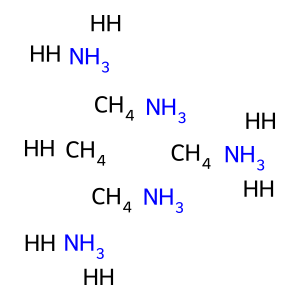

Step 1:


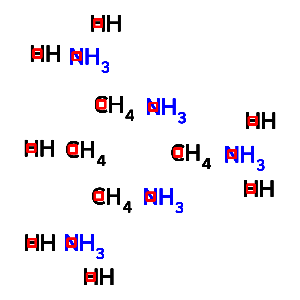

Step 2:


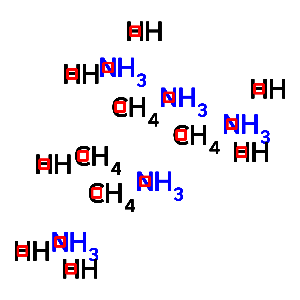

Step 3:


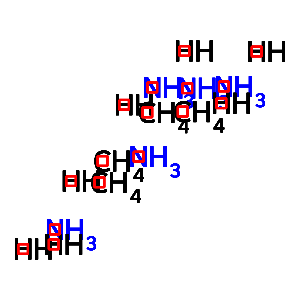

Step 4:


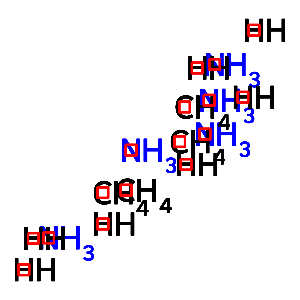

Step 5:


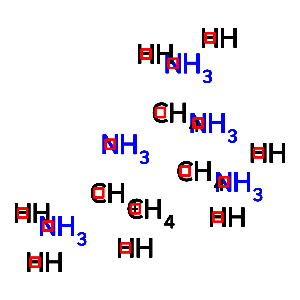

Step 6:


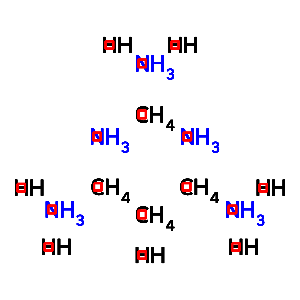

Step 7:


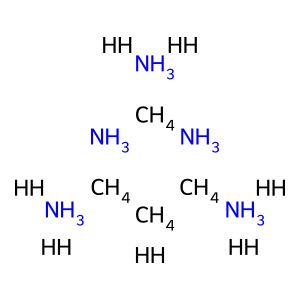

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolInterchange

def visualize_interpolation(start_coords, end_coords, num_interpolation_steps=5):
    # Convert start_coords and end_coords to RDKit molecules
    start_mol = visualize_molecule(start_coords)
    end_mol = visualize_molecule(end_coords)
    
    # Perform interpolation
    interpolated_mols = []
    for i in range(num_interpolation_steps + 1):
        ratio = i / num_interpolation_steps
        internal_coords = cartesian_to_internal(start_coords)
        interpolated_coords = internal_to_cartesian(internal_coords, ratio, start_coords, end_coords)
        interpolated_mol = visualize_molecule(interpolated_coords)
        interpolated_mols.append(interpolated_mol)
    
    # Visualize the interpolation
    images = [Draw.MolToImage(mol) for mol in [start_mol] + interpolated_mols + [end_mol]]
    return images

# Visualize the interpolation
interpolation_images = visualize_interpolation(start_coords, end_coords)
for i, image in enumerate(interpolation_images):
    print(f"Step {i}:")
    display(image)
